In [18]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy import signal
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

## Model

In [19]:
traindf = pd.read_hdf(dir+'NormalityTrain.h5')
testdf = pd.read_hdf(dir+'NormalityTest.h5')

In [20]:
scaler = MinMaxScaler().fit(traindf[traindf.columns])
traindf[traindf.columns]=scaler.transform(traindf[traindf.columns])
testdf[testdf.columns]=scaler.transform(testdf[testdf.columns])

In [21]:
distance=smf.ols(formula=""" distance ~ 
mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
wf_min+wf_max+wf_mean+wf_std_dev+wf_k+
wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
ma_min+ma_max+ma_mean+ma_std_dev+ma_k+
st_min+st_max+st_mean+st_std_dev+st_k """, data=traindf).fit()

print(distance.rsquared)

0.6834278024964385


## Normality Analysis

### Breusch Pagan Test
more about BP Test: https://stats.stackexchange.com/questions/155495/what-is-criterion-for-breusch-pagan-test
https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test

In [22]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(distance.resid, distance.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 210.45571051310782),
 ('p-value', 2.9383913374787177e-31),
 ('f-value', 9.69148296154862),
 ('f p-value', 3.7887219617642405e-34)]

###### Diagnostic plots

Let's check that the assumptions of the model have not been violated. Specifically, we look to see:

* the residuals are well distributed (standardized residuals vs predicted)
* the residuals follow a normal distribution (shapiro-wilks test) since we are using a linear model, not generalized
* check the heteroscedasticity (Q-Q plot)
* the variance is not a function of the output (observed vs predicted)
As with the $R^2$ situation, we will look at predictions and residuals that include the fixed and random effects, or only the fixed, since we are using a mixed effects linear model.

Some useful stuff:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

### Actual vs Predicted

The scatter data should fall evenly around the red line, without any major patterns.

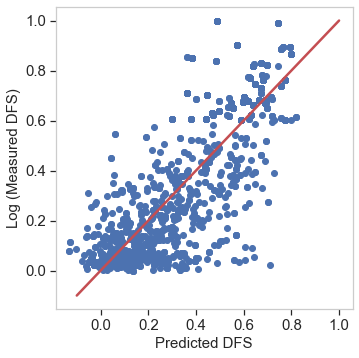

In [27]:
f,ax=plt.subplots(1,1,figsize=(5,5))
b, a = np.polyfit(distance.fittedvalues,traindf.distance, deg=1)
xseq = np.linspace(-.1, 1, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Log (Measured DFS)')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, traindf.distance)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/qq.jpeg', dpi=300, bbox_inches = "tight")

### Standardized residuals

Standardized residuals = (observed - expected) / std_dev(expected)

The scatter should be evenly distributed around the red line, without any obvious patterns, like growing or shrinking residuals as a function of predicted value.

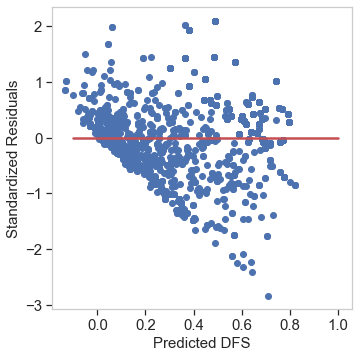

In [29]:
f,ax=plt.subplots(1,1,figsize=(5,5))
standardized_residuals = (traindf.distance - distance.fittedvalues) / np.std(distance.fittedvalues)
b, a = np.polyfit(distance.fittedvalues, standardized_residuals, deg=1)
xseq = np.linspace(-.1, 1, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Standardized Residuals')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, standardized_residuals)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/StdResid.jpeg', dpi=300, bbox_inches = "tight")

### Residual Analysis
### Q-Q plot

The scatter should follow the red line, especially in the middle. Looks pretty good here. The plots shows there is a central peak in distribution

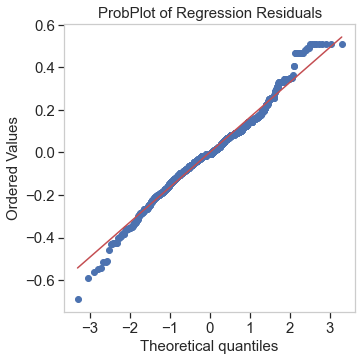

In [30]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.grid(False)
stats.probplot(distance.resid,plot=ax)
f.tight_layout(pad=1)
# f.suptitle('Q-Q Plot')
ax.set_title('ProbPlot of Regression Residuals')
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/qq.jpeg', dpi=300, bbox_inches = "tight")